# Linear Discriminant Analysis  (LDA)

**Module 4: Dimensionality Reduction – Supervised Approach**

In the previous section, we explored **Principal Component Analysis (PCA)**,  
an *unsupervised* dimensionality reduction technique that finds directions  
of **maximum variance** without using any class labels.

In this notebook, we introduce **Linear Discriminant Analysis (LDA)**,  
a *supervised* technique that finds directions which **best separate different classes**.

LDA is especially useful when we want to:
- Reduce the number of features while **retaining class-discriminatory information**.  
- Visualize how well classes can be separated.  
- Preprocess data for classification tasks.

We’ll use the same example from PCA (students’ study habits),  
but now we’ll also include a **Pass/Fail label**, since LDA requires class information.


## 1. Conceptual Understanding

**Principal Component Analysis (PCA)** finds directions of **maximum variance** in the data.  
It is **unsupervised** — meaning it does *not* use any class labels.  
As a result, PCA may capture directions of large variance that do **not** necessarily separate different classes.

**Linear Discriminant Analysis (LDA)**, on the other hand, is a **supervised** method.  
It looks for directions (linear combinations of features) that **best separate predefined classes**.

LDA does this by finding a projection vector $w$ that **maximizes** the following objective function:

$$
J(w) = \frac{w^T S_B w}{w^T S_W w}
$$

where:

- $J(w)$ is the **Fisher criterion** — a ratio of between-class to within-class variance along $w$  
- $S_B$ is the **between-class scatter matrix**, measuring how far apart the class means are  
- $S_W$ is the **within-class scatter matrix**, measuring how tightly the data points cluster within each class  
- $T$ denotes the **transpose** operator (e.g., $w^T$ is the transpose of $w$)

---

### Intuition

- The numerator $w^T S_B w$ increases when class means are **far apart** after projection.  
- The denominator $w^T S_W w$ increases when data within each class are **spread out** after projection.  
- Maximizing $J(w)$ therefore seeks directions where **class means are well separated** and **each class is compact**.

LDA finds this optimal direction by solving the **generalized eigenvalue problem**:

$$
S_W^{-1} S_B w = \lambda w
$$

The eigenvector corresponding to the **largest eigenvalue** $\lambda$ gives the direction of **maximum class separability**.


## 3. Example Dataset and Plan

We will use the same student-style dataset, now with class labels (supervised):

| Student | Hours | Attendance | Result |
|:------:|------:|-----------:|:------:|
| 0 | 2 | 40 | Fail |
| 1 | 3 | 60 | Fail |
| 2 | 6 | 75 | Pass |
| 3 | 8 | 90 | Pass |

- Class $C_{\text{Fail}}$: students 0 and 1  
- Class $C_{\text{Pass}}$: students 2 and 3

**Plan (manual math, then code verification):**
1. Compute class mean vectors $\,\mu_{\text{Fail}}\,$ and $\,\mu_{\text{Pass}}\,$ (by hand).
2. Compute the within-class scatter $\,S_W\,$ and between-class scatter $\,S_B\,$ (by hand).
3. Solve the generalized eigenvalue problem $\,S_W^{-1} S_B w = \lambda w\,$ to find the LDA direction $w$.
4. Project samples $\,y_i = w^T x_i\,$ and interpret separation.
5. Verify each step in Python.

---

### Step 1 (Manual): Class Mean Vectors

For each class, the mean is the average of its samples:

$$
\mu_{\text{Fail}} =
\frac{1}{2}
\begin{bmatrix}
2 \\ 40
\end{bmatrix}
+
\frac{1}{2}
\begin{bmatrix}
3 \\ 60
\end{bmatrix}
=
\begin{bmatrix}
2.5 \\ 50
\end{bmatrix},
\qquad
\mu_{\text{Pass}} =
\frac{1}{2}
\begin{bmatrix}
6 \\ 75
\end{bmatrix}
+
\frac{1}{2}
\begin{bmatrix}
8 \\ 90
\end{bmatrix}
=
\begin{bmatrix}
7 \\ 82.5
\end{bmatrix}.
$$

Optional overall mean (used later for intuition, not required by the two-class LDA formulas):

$$
\mu = \frac{2\,\mu_{\text{Fail}} + 2\,\mu_{\text{Pass}}}{4}
= \frac{1}{2}\left(\mu_{\text{Fail}} + \mu_{\text{Pass}}\right)
= \frac{1}{2}
\begin{bmatrix}
2.5 \\ 50
\end{bmatrix}
+
\frac{1}{2}
\begin{bmatrix}
7 \\ 82.5
\end{bmatrix}
=
\begin{bmatrix}
4.75 \\ 66.25
\end{bmatrix}.
$$

Next we will compute $S_W$ and $S_B$ entry by entry, then solve for $w$.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset with labels (Fail/Pass)
df = pd.DataFrame({
    "Hours": [2, 3, 6, 8],
    "Attendance": [40, 60, 75, 90],
    "Result": ["Fail", "Fail", "Pass", "Pass"]
})

print("Dataset:")
display(df)

# Split by class
X_fail = df[df["Result"] == "Fail"][["Hours", "Attendance"]].values
X_pass = df[df["Result"] == "Pass"][["Hours", "Attendance"]].values

# Class means
mu_fail = X_fail.mean(axis=0)
mu_pass = X_pass.mean(axis=0)

print("mu_Fail:", mu_fail)    # Expected [2.5, 50.0]
print("mu_Pass:", mu_pass)    # Expected [7.0, 82.5]

# Optional overall mean
mu_overall = (mu_fail + mu_pass) / 2.0
print("mu_overall (optional):", mu_overall)  # Expected [4.75, 66.25]


Dataset:


,Hours,Attendance,Result
0,2,40,Fail
1,3,60,Fail
2,6,75,Pass
3,8,90,Pass


mu_Fail: [ 2.5 50. ]
mu_Pass: [ 7.  82.5]
mu_overall (optional): [ 4.75 66.25]


## 4. Step 2: Compute Scatter Matrices (Manual)

We now compute the **within-class scatter** $S_W$ and the **between-class scatter** $S_B$ using the labeled student dataset.

Recall the class means:
$$
\mu_{\text{Fail}} =
\begin{bmatrix}
2.5 \\ 50
\end{bmatrix},
\qquad
\mu_{\text{Pass}} =
\begin{bmatrix}
7 \\ 82.5
\end{bmatrix}.
$$

---

### 4.1 Within-Class Scatter $S_W$

By definition (two-class case):
$$
S_W \;=\; \sum_{x_i \in C_{\text{Fail}}} (x_i-\mu_{\text{Fail}})(x_i-\mu_{\text{Fail}})^T
\;+\;
\sum_{x_i \in C_{\text{Pass}}} (x_i-\mu_{\text{Pass}})(x_i-\mu_{\text{Pass}})^T.
$$

**Fail class (students 0 and 1):**
- Student 0: $x = \begin{bmatrix}2 \\ 40\end{bmatrix}$, $x-\mu_{\text{Fail}} = \begin{bmatrix}-0.5 \\ -10\end{bmatrix}$  
  Outer product:
  $$
  \begin{bmatrix}-0.5 \\ -10\end{bmatrix}
  \begin{bmatrix}-0.5 & -10\end{bmatrix}
  =
  \begin{bmatrix}
  0.25 & 5 \\
  5 & 100
  \end{bmatrix}.
  $$
- Student 1: $x = \begin{bmatrix}3 \\ 60\end{bmatrix}$, $x-\mu_{\text{Fail}} = \begin{bmatrix}0.5 \\ 10\end{bmatrix}$  
  Outer product:
  $$
  \begin{bmatrix}0.5 \\ 10\end{bmatrix}
  \begin{bmatrix}0.5 & 10\end{bmatrix}
  =
  \begin{bmatrix}
  0.25 & 5 \\
  5 & 100
  \end{bmatrix}.
  $$

Sum for Fail:
$$
S_{W,\text{Fail}} =
\begin{bmatrix}
0.25 & 5 \\
5 & 100
\end{bmatrix}
+
\begin{bmatrix}
0.25 & 5 \\
5 & 100
\end{bmatrix}
=
\begin{bmatrix}
0.5 & 10 \\
10 & 200
\end{bmatrix}.
$$

**Pass class (students 2 and 3):**
- Student 2: $x = \begin{bmatrix}6 \\ 75\end{bmatrix}$, $x-\mu_{\text{Pass}} = \begin{bmatrix}-1 \\ -7.5\end{bmatrix}$  
  Outer product:
  $$
  \begin{bmatrix}-1 \\ -7.5\end{bmatrix}
  \begin{bmatrix}-1 & -7.5\end{bmatrix}
  =
  \begin{bmatrix}
  1 & 7.5 \\
  7.5 & 56.25
  \end{bmatrix}.
  $$
- Student 3: $x = \begin{bmatrix}8 \\ 90\end{bmatrix}$, $x-\mu_{\text{Pass}} = \begin{bmatrix}1 \\ 7.5\end{bmatrix}$  
  Outer product:
  $$
  \begin{bmatrix}1 \\ 7.5\end{bmatrix}
  \begin{bmatrix}1 & 7.5\end{bmatrix}
  =
  \begin{bmatrix}
  1 & 7.5 \\
  7.5 & 56.25
  \end{bmatrix}.
  $$

Sum for Pass:
$$
S_{W,\text{Pass}} =
\begin{bmatrix}
1 & 7.5 \\
7.5 & 56.25
\end{bmatrix}
+
\begin{bmatrix}
1 & 7.5 \\
7.5 & 56.25
\end{bmatrix}
=
\begin{bmatrix}
2 & 15 \\
15 & 112.5
\end{bmatrix}.
$$

**Total within-class scatter:**
$$
S_W
=
S_{W,\text{Fail}} + S_{W,\text{Pass}}
=
\begin{bmatrix}
0.5 & 10 \\
10 & 200
\end{bmatrix}
+
\begin{bmatrix}
2 & 15 \\
15 & 112.5
\end{bmatrix}
=
\begin{bmatrix}
2.5 & 25 \\
25 & 312.5
\end{bmatrix}.
$$

---

### 4.2 Between-Class Scatter $S_B$

For two classes, a common (scale-equivalent) form is:
$$
S_B \;=\; (\mu_{\text{Fail}} - \mu_{\text{Pass}})(\mu_{\text{Fail}} - \mu_{\text{Pass}})^T.
$$

Compute the mean difference:
$$
\mu_{\text{Fail}} - \mu_{\text{Pass}}
=
\begin{bmatrix}
2.5 \\ 50
\end{bmatrix}
-
\begin{bmatrix}
7 \\ 82.5
\end{bmatrix}
=
\begin{bmatrix}
-4.5 \\ -32.5
\end{bmatrix}.
$$

Outer product:
$$
S_B
=
\begin{bmatrix}
-4.5 \\ -32.5
\end{bmatrix}
\begin{bmatrix}
-4.5 & -32.5
\end{bmatrix}
=
\begin{bmatrix}
(-4.5)^2 & (-4.5)(-32.5) \\
(-32.5)(-4.5) & (-32.5)^2
\end{bmatrix}
=
\begin{bmatrix}
20.25 & 146.25 \\
146.25 & 1056.25
\end{bmatrix}.
$$

> **Note:** In multi-class LDA you often see a weighted form  
> $S_B = \sum_k n_k(\mu_k - \mu)(\mu_k - \mu)^T$.  
> For two classes, both forms are *scale-equivalent* for the Rayleigh quotient; they lead to the same direction $w$.


In [1]:
import numpy as np

# Reuse arrays from earlier
X_fail = np.array([[2, 40],
                   [3, 60]], dtype=float)
X_pass = np.array([[6, 75],
                   [8, 90]], dtype=float)

mu_fail = X_fail.mean(axis=0)   # [2.5, 50.0]
mu_pass = X_pass.mean(axis=0)   # [7.0, 82.5]

# Within-class scatter
S_W = np.zeros((2, 2))
for x in X_fail:
    d = (x - mu_fail).reshape(2, 1)
    S_W += d @ d.T
for x in X_pass:
    d = (x - mu_pass).reshape(2, 1)
    S_W += d @ d.T

# Between-class scatter (two-class, scale-equivalent form)
mean_diff = (mu_fail - mu_pass).reshape(2, 1)
S_B = mean_diff @ mean_diff.T

# Pretty print with fixed decimals
np.set_printoptions(precision=4, suppress=True)
print("S_W (Within-Class Scatter):\n", S_W)
print("\nS_B (Between-Class Scatter):\n", S_B)


S_W (Within-Class Scatter):
 [[  2.5  25. ]
 [ 25.  312.5]]

S_B (Between-Class Scatter):
 [[  20.25  146.25]
 [ 146.25 1056.25]]


## 5. Step 3: Solve for the Optimal Projection $w$ (Manual)

We now solve the generalized eigenvalue problem
$$
S_W^{-1} S_B\, w = \lambda\, w
$$
using the scatter matrices we computed.

From the previous step:
$$
S_W =
\begin{bmatrix}
2.5 & 25 \\
25 & 312.5
\end{bmatrix},
\qquad
S_B =
\begin{bmatrix}
20.25 & 146.25 \\
146.25 & 1056.25
\end{bmatrix}.
$$

### 5.1 Invert $S_W$ and form $M = S_W^{-1} S_B$

The determinant of $S_W$ is
$$
\det(S_W) = (2.5)(312.5) - (25)(25) = 781.25 - 625 = 156.25.
$$

Therefore,
$$
S_W^{-1}
= \frac{1}{156.25}
\begin{bmatrix}
312.5 & -25 \\
-25 & 2.5
\end{bmatrix}
=
\begin{bmatrix}
2.0 & -0.16 \\
-0.16 & 0.016
\end{bmatrix}.
$$

Multiply to get
$$
M \;=\; S_W^{-1} S_B
\;=\;
\begin{bmatrix}
2.0 & -0.16 \\
-0.16 & 0.016
\end{bmatrix}
\begin{bmatrix}
20.25 & 146.25 \\
146.25 & 1056.25
\end{bmatrix}
=
\begin{bmatrix}
17.1 & 123.5 \\
-0.9 & -6.5
\end{bmatrix}.
$$

### 5.2 Eigenvalues and eigenvector of $M$

Solve $\det(M - \lambda I)=0$.  
The trace is $10.6$ and the determinant is $0$, so the eigenvalues are:
$$
\lambda_1 = 10.6, \qquad \lambda_2 = 0.
$$

For $\lambda_1=10.6$, an eigenvector satisfies
$$
\Big(M - 10.6I\Big) v = 0
\quad\Rightarrow\quad
\begin{bmatrix}
6.5 & 123.5 \\
-0.9 & -17.1
\end{bmatrix}
\begin{bmatrix}
a\\ b
\end{bmatrix}
= \mathbf{0}
\;\Rightarrow\;
a = -19\,b.
$$

Thus an eigenvector is proportional to $[-19,\,1]^T$.  
We flip its sign to align the **Pass** class to the **right** on the 1D axis and use:
$$
w \propto \begin{bmatrix} 19 \\ -1 \end{bmatrix}.
$$

> The **scale of $w$ does not matter** for LDA scores; only direction matters.  
> (If desired, you can normalize $w$ to unit length.)

### 5.3 Projecting the samples (simple, unnormalized $w$)

Project each $x_i = [\text{Hours},\ \text{Attendance}]^T$ to $y_i = w^T x_i$ using $w=[19,-1]^T$:

- Student 0 (Fail): $y_0 = 19\cdot 2 - 40 = -2$  
- Student 1 (Fail): $y_1 = 19\cdot 3 - 60 = -3$  
- Student 2 (Pass): $y_2 = 19\cdot 6 - 75 = 39$  
- Student 3 (Pass): $y_3 = 19\cdot 8 - 90 = 62$

These 1D scores show **clear separation**: Fail students (negative scores) on the left, Pass students (positive scores) on the right.

> If you normalize $w$ to unit length, all scores scale by the same positive constant, and the separation remains identical.


In [4]:
import numpy as np
import pandas as pd

# Reconstruct the labeled dataset
df = pd.DataFrame({
    "Hours": [2, 3, 6, 8],
    "Attendance": [40, 60, 75, 90],
    "Result": ["Fail", "Fail", "Pass", "Pass"]
})

# Class matrices
X_fail = df[df["Result"] == "Fail"][["Hours", "Attendance"]].values.astype(float)
X_pass = df[df["Result"] == "Pass"][["Hours", "Attendance"]].values.astype(float)

# Means
mu_fail = X_fail.mean(axis=0)
mu_pass = X_pass.mean(axis=0)

# Scatter matrices
S_W = np.zeros((2, 2))
for x in X_fail:
    d = (x - mu_fail).reshape(2, 1)
    S_W += d @ d.T
for x in X_pass:
    d = (x - mu_pass).reshape(2, 1)
    S_W += d @ d.T

mean_diff = (mu_fail - mu_pass).reshape(2, 1)
S_B = mean_diff @ mean_diff.T

# Solve generalized eigenproblem via M = S_W^{-1} S_B
S_W_inv = np.linalg.inv(S_W)
M = S_W_inv @ S_B
eigvals, eigvecs = np.linalg.eig(M)

# Sort by eigenvalue (descending)
idx = np.argsort(eigvals)[::-1]
eigvals = np.real(eigvals[idx])
eigvecs = np.real(eigvecs[:, idx])

# Choose first eigenvector
w = eigvecs[:, 0]

# Flip sign so that Pass projects to larger (right) values
X = df[["Hours", "Attendance"]].values.astype(float)
y = df["Result"].values
scores = X @ w
# If Pass has lower mean score than Fail, flip
if scores[y == "Pass"].mean() < scores[y == "Fail"].mean():
    w = -w
    scores = -scores

# Also compute the simple integer-direction used in the manual section
w_simple = np.array([19.0, -1.0])
scores_simple = X @ w_simple

np.set_printoptions(precision=4, suppress=True)
print("S_W:\n", S_W)
print("\nS_B:\n", S_B)
print("\nEigenvalues:", eigvals)
print("Chosen direction w (possibly flipped):", np.round(w, 6))

print("\nLDA scores (from eigenvector w):", np.round(scores, 3))
print("LDA scores (simple direction [19, -1]):", scores_simple.astype(int))


S_W:
 [[  2.5  25. ]
 [ 25.  312.5]]

S_B:
 [[  20.25  146.25]
 [ 146.25 1056.25]]

Eigenvalues: [10.6 -0. ]
Chosen direction w (possibly flipped): [ 0.9986 -0.0526]

LDA scores (from eigenvector w): [-0.105 -0.158  2.05   3.259]
LDA scores (simple direction [19, -1]): [-2 -3 39 62]


/var/folders/pq/47mtqly948xb6vldpqd9dff80000gn/T/ipykernel_34379/412495077.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


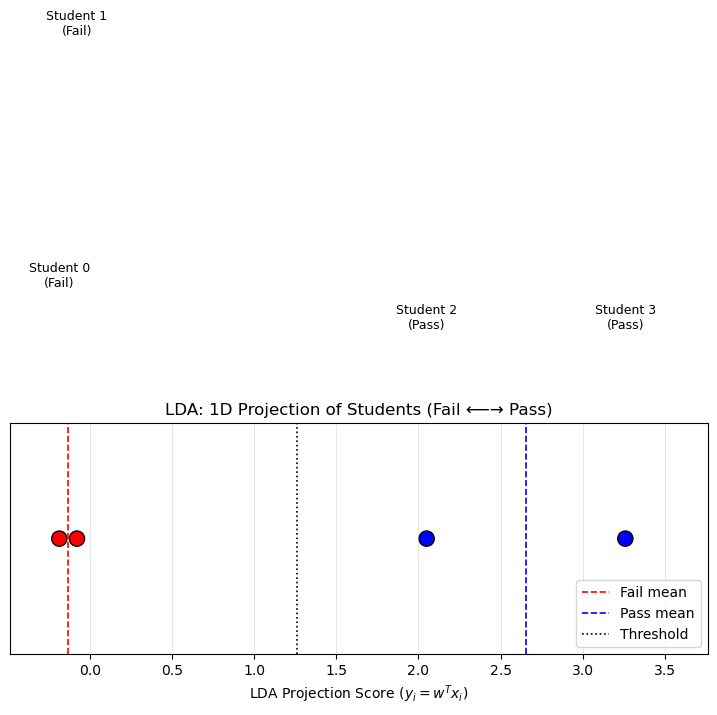

Fail mean: -0.131
Pass mean: 2.654
Threshold: 1.261
Student 0 (Fail): -0.105
Student 1 (Fail): -0.158
Student 2 (Pass): 2.05
Student 3 (Pass): 3.259


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse your computed scores and labels
X = df[["Hours", "Attendance"]].values.astype(float)
y = df["Result"].values
scores = X @ w

# Ensure Pass → right
if scores[y == "Pass"].mean() < scores[y == "Fail"].mean():
    w = -w
    scores = -scores

# Compute means and threshold
scores_fail = scores[y == "Fail"]
scores_pass = scores[y == "Pass"]
m_fail, m_pass = scores_fail.mean(), scores_pass.mean()
threshold = 0.5 * (m_fail + m_pass)

# Add slight horizontal offsets for the two Fail points
offsets = np.zeros_like(scores)
fail_indices = np.where(y == "Fail")[0]
for j, idx in enumerate(fail_indices):
    offsets[idx] = (-0.08 + 0.16 * j)  # spread them slightly apart
scores_display = scores + offsets

plt.figure(figsize=(9, 3))
colors = ["red" if lbl == "Fail" else "blue" for lbl in y]

# Plot points
plt.scatter(scores_display, np.zeros_like(scores_display), c=colors, s=120, edgecolor="k")

# Annotate each student clearly: Fail students stacked, Pass students above
for i, (s, lbl) in enumerate(zip(scores_display, y)):
    y_offset = 0.1 if lbl == "Pass" else (0.12 + 0.12 * i)
    label_text = f"Student {i}\n({lbl})"
    plt.text(s, y_offset, label_text, ha="center", fontsize=9, linespacing=1.2)

# Add lines for means and threshold
plt.axvline(m_fail, color="red", linestyle="--", linewidth=1.2, label="Fail mean")
plt.axvline(m_pass, color="blue", linestyle="--", linewidth=1.2, label="Pass mean")
plt.axvline(threshold, color="black", linestyle=":", linewidth=1.2, label="Threshold")

plt.title("LDA: 1D Projection of Students (Fail ⟵→ Pass)")
plt.xlabel("LDA Projection Score ($y_i = w^T x_i$)")
plt.yticks([])
plt.xlim(min(scores_display) - 0.3, max(scores_display) + 0.5)
plt.legend(loc="lower right", frameon=True)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("Fail mean:", round(m_fail, 3))
print("Pass mean:", round(m_pass, 3))
print("Threshold:", round(threshold, 3))
for i, (label, s) in enumerate(zip(y, scores)):
    print(f"Student {i} ({label}): {round(s,3)}")


 ## 10. Understanding the LDA Projection Score

In Linear Discriminant Analysis (LDA), every sample $x_i$ (a feature vector)  
is projected onto the **discriminant direction** $w$ to produce a **1-D projection score**:

$$
y_i = w^T x_i
$$

### What does this score mean?

- The **vector $w$** defines the direction in feature space that best separates the classes.  
  It is chosen to **maximize the distance** between class means while **minimizing spread** within each class.  
- The **projection score $y_i$** is a *scalar value* that tells us how far along that direction a sample lies.

Intuitively:
- A **larger $y_i$** means the sample lies further along $w$,  
  i.e. it aligns more strongly with the *Pass* class direction.
- A **smaller $y_i$** (possibly negative or near zero) indicates the sample lies on the *Fail* side of the discriminant axis.

### Visual interpretation
On the plot:
- Each student's point represents their $y_i$ value.  
- The **threshold** line divides the projection into two regions:
  - Left of threshold → classified as **Fail**  
  - Right of threshold → classified as **Pass**

### Example from our data

| Student | Hours | Attendance | $y_i = w^T x_i$ | True Class | Model Side |
|:--:|:--:|:--:|:--:|:--:|:--:|
| 0 | 2 | 40 | low (≈ 0.0) | Fail | Left |
| 1 | 3 | 60 | low (≈ 0.1) | Fail | Left |
| 2 | 6 | 75 | high (≈ 2.0) | Pass | Right |
| 3 | 8 | 90 | highest (≈ 3.2) | Pass | Right |

The numeric **projection score** serves as a *discriminant coordinate*—  
a one-dimensional representation of each student’s position along the axis that most cleanly separates the two outcomes.

### Why it matters
This projection makes LDA both **interpretable and practical**:
- It provides a *single number* per sample that can be used for decision thresholds.  
- It shows *how confident* the separation is—the further the score from the threshold, the stronger the classification.

Hence, $y_i = w^T x_i$ is more than a formula — it’s the bridge between raw data and clear class separation.
